# 0. Setup

## 0.1 Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image
import numpy as np
import glob, os, random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

## 0.2 Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 0.3 Constants

In [3]:
IMG_SIZE = 64
LATENT_DIM = 32
DATA_PATHS = [
    "/kaggle/input/chess-squares/black/*.png",
    "/kaggle/input/chess-squares/white/*.png",
]
VIEWS_PER_IMAGE = 16

piece_map = {
    'wp': 0, 'wn': 1, 'wb': 2, 'wr': 3, 'wq': 4, 'wk': 5,
    'bp': 6, 'bn': 7, 'bb': 8, 'br': 9, 'bq': 10, 'bk': 11,
    'empty': 12 # empty square
}

## 0.4 Transforms

In [4]:
base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.ToTensor(),
])

## 0.5 Functions

In [5]:
def visualize_embedding_space(embedding_vectors, piece_labels, piece_images, 
                             image_config=None, zoom=0.5):
    """
    Visualize learned 2d-projected embeddings (latents/features).
    Works for both autoencoder latents and contrastive learning features.
    """
    if image_config is None:
        image_config = {}

    class_names = [
        'W-Pawn', 'W-Knight', 'W-Bishop', 'W-Rook', 'W-Queen', 'W-King',
        'B-Pawn', 'B-Knight', 'B-Bishop', 'B-Rook', 'B-Queen', 'B-King',
        'Empty'
    ]

    white_colors = ['#A6CEE3', '#B2DF8A', '#FB9A99', '#FFFF99', '#CAB2D6', '#FDBF6F']
    black_colors = ['#1F78B4', '#33A02C', '#E31A1C', '#FF7F00', '#6A3D9A', '#B15928']
    empty_color = ['#DDDDDD']
    all_colors = white_colors + black_colors + empty_color

    plt.figure(figsize=(14, 10))
    ax = plt.gca()

    for piece_code, piece_idx in piece_map.items():
        class_name = class_names[piece_idx]
        class_color = all_colors[piece_idx]

        # Get indices for this piece class
        class_indices = np.where(piece_labels == piece_idx)[0]
        if class_indices.size == 0:
            continue

        # Scatter: class cloud
        ax.scatter(
            embedding_vectors[class_indices, 0],
            embedding_vectors[class_indices, 1],
            c=class_color,
            label=class_name,
            alpha=0.9,
            s=100,
            edgecolors='white'
        )

        # Number of images to overlay for this class
        num_images_to_show = image_config.get(piece_code, 0)
        selected_indices = (
            np.random.choice(class_indices, num_images_to_show, replace=False)
            if class_indices.size > num_images_to_show else class_indices
        )

        # Overlay images
        for idx in selected_indices:
            img = piece_images[idx]
            x_coord, y_coord = embedding_vectors[idx]

            annotation_box = AnnotationBbox(
                OffsetImage(img, zoom=zoom, cmap='gray'),
                (x_coord, y_coord),
                frameon=True,
                pad=0.1,
                bboxprops=dict(edgecolor=class_color, linewidth=1)
            )
            ax.add_artist(annotation_box)

    # Styling
    ax.set_title("Embedding Space Visualization", fontsize=20)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Piece Type")
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# 1. Autoencoder

## 1.1 Dataset

In [6]:
class AutoencoderDataset(Dataset):
    """Loads all images in RAM to speed up autoencoder training."""

    def __init__(self, data_glob_paths):
        # Allow single string or list
        if isinstance(data_glob_paths, str):
            data_glob_paths = [data_glob_paths]

        self.images = []
        self.labels = []

        image_paths = []
        for path in data_glob_paths:
            image_paths.extend(glob.glob(path))

        total = len(image_paths)
        print(f"Loading {total} images...")

        for i, img_path in enumerate(image_paths):
            if i > 0 and i % 1000 == 0:
                print(f"Processed {i}/{total} images...")

            piece_code = os.path.basename(img_path).split('_', 1)[0]
            if piece_code not in piece_map:
                print(piece_code)
                continue

            img = Image.open(img_path).convert('L')
            self.images.append(base_transform(img))
            self.labels.append(piece_map[piece_code])

        print(f"Loaded {len(self.images)} valid samples.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

## 1.2 Model

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, 2, 1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

## 1.3 Training

In [8]:
ae_dataset = AutoencoderDataset(DATA_PATHS)
ae_dataloader = DataLoader(
    ae_dataset,
    batch_size=512,
    shuffle=True,
    drop_last=True
)

Loading 16247 images...
Processed 1000/16247 images...
Processed 2000/16247 images...
Processed 3000/16247 images...
Processed 4000/16247 images...
Processed 5000/16247 images...
Processed 6000/16247 images...
Processed 7000/16247 images...
Processed 8000/16247 images...
Processed 9000/16247 images...
Processed 10000/16247 images...
Processed 11000/16247 images...
Processed 12000/16247 images...
Processed 13000/16247 images...
Processed 14000/16247 images...
Processed 15000/16247 images...
Processed 16000/16247 images...
Loaded 16247 valid samples.


Training Autoencoder...
Epoch 10: 0.03364
Epoch 20: 0.02879
Epoch 30: 0.02621
Epoch 40: 0.02480
Epoch 50: 0.02382
Epoch 60: 0.02311
Epoch 70: 0.02266
Epoch 80: 0.02213
Epoch 90: 0.02173
Epoch 100: 0.02148


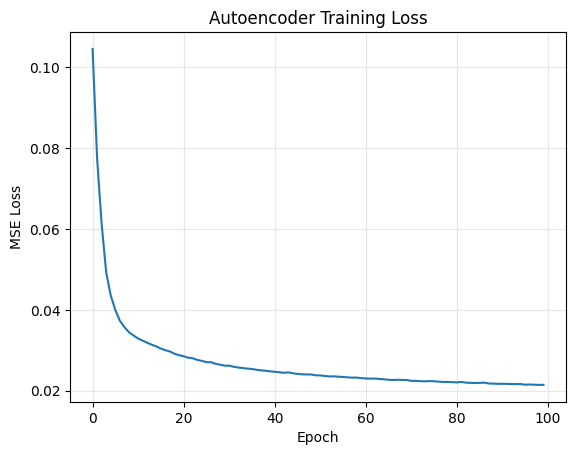

In [9]:
ae_model = Autoencoder().to(device)
ae_optimizer = optim.Adam(ae_model.parameters(), lr=1e-3)
ae_criterion = nn.MSELoss()

ae_losses = []
AE_EPOCHS = 100

print("Training Autoencoder...")
for epoch in range(AE_EPOCHS):
    epoch_loss = 0
    for batch_images, _ in ae_dataloader:
        batch_images = batch_images.to(device)

        ae_optimizer.zero_grad()
        reconstructed_images = ae_model(batch_images)
        loss = ae_criterion(reconstructed_images, batch_images)
        loss.backward()
        ae_optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(ae_dataloader)
    ae_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: {avg_loss:.5f}")

plt.plot(ae_losses)
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(alpha=0.3)
plt.show()

## 1.4 Extract Latents

In [10]:
ae_model.eval()
ae_latent_vectors = []
ae_piece_labels = []
ae_piece_images = []

with torch.no_grad():
    for batch_images, batch_labels in ae_dataloader:
        batch_images = batch_images.to(device)
        batch_latents = ae_model.encoder(batch_images)

        ae_latent_vectors.append(batch_latents.cpu().numpy())
        ae_piece_labels.append(batch_labels.numpy())
        ae_piece_images.append(batch_images.cpu().squeeze().numpy())

ae_latent_vectors = np.concatenate(ae_latent_vectors)
ae_piece_labels = np.concatenate(ae_piece_labels)
ae_piece_images = np.concatenate(ae_piece_images)

print("Autoencoder latent shape:", ae_latent_vectors.shape)

Autoencoder latent shape: (15872, 32)


## 1.5 Visualization

In [11]:
tsne_ae = TSNE(n_components=2, perplexity=40, random_state=42)
ae_latent_2d = tsne_ae.fit_transform(ae_latent_vectors)

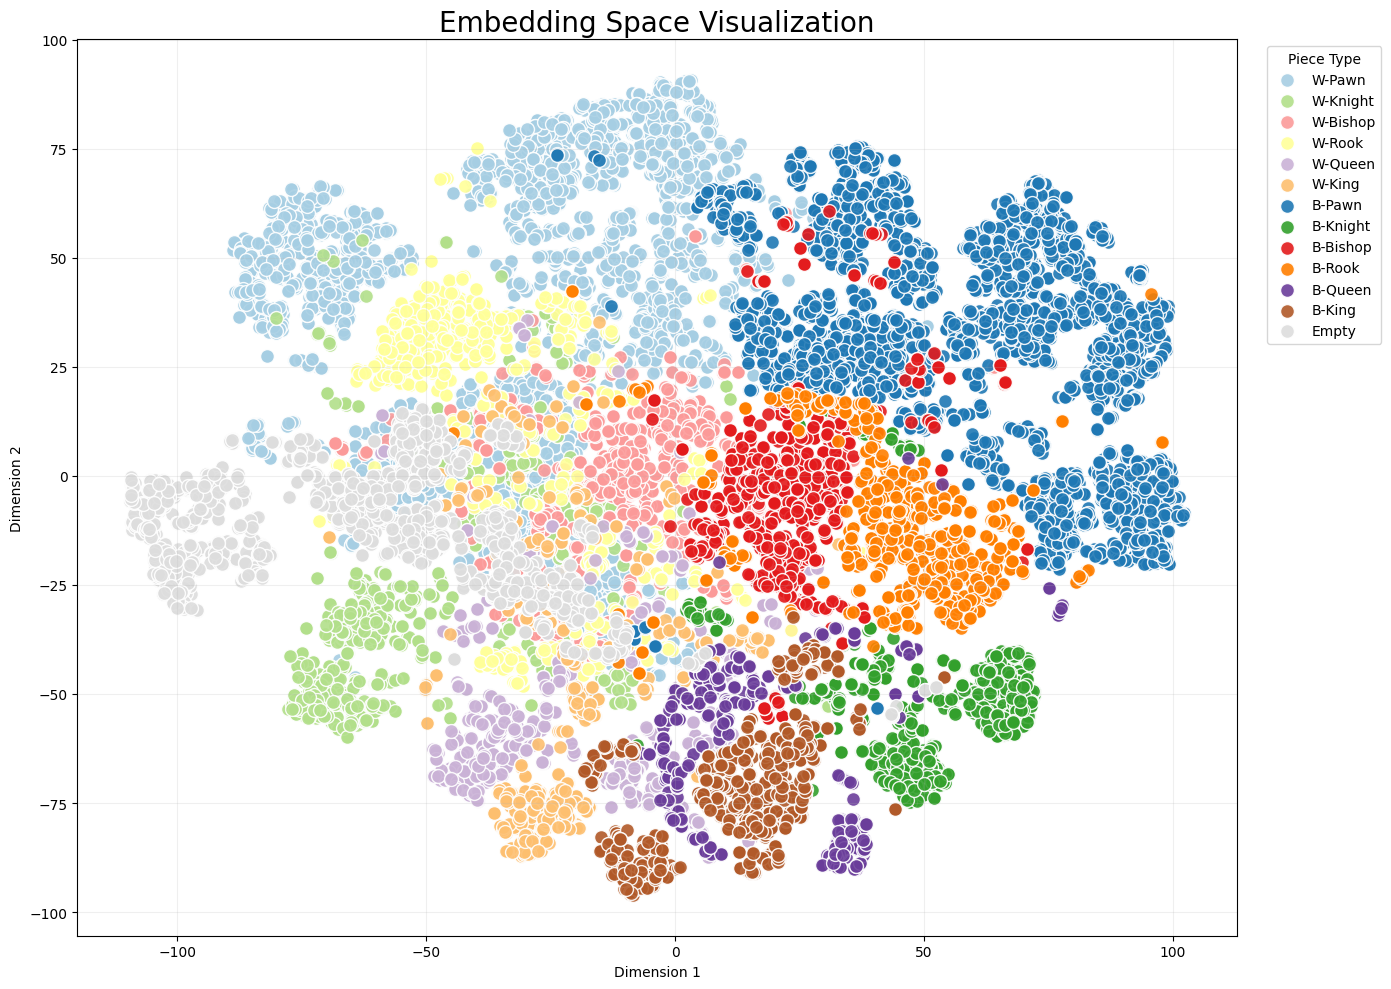

In [12]:
visualize_embedding_space(
    ae_latent_2d,
    ae_piece_labels,
    ae_piece_images,
    #image_config={'wk':20, "wq":20}
)

# 2. SimCLR

## 2.1 Dataset

In [13]:
class SimCLRDataset(Dataset):
    """Each image has 16 cached augmented views + original."""
    """Each image has cached augmented views + original."""

    def __init__(self, data_glob_paths, views_per_image=VIEWS_PER_IMAGE):
        # Allow single string or list of strings
        if isinstance(data_glob_paths, str):
            data_glob_paths = [data_glob_paths]

        self.data = []
        self.views_per_image = views_per_image

        image_paths = []
        for path in data_glob_paths:
            image_paths.extend(glob.glob(path))

        total = len(image_paths)
        print(f"Generating {views_per_image} views per image for {total} files...")

        for i, img_path in enumerate(image_paths):
            # Progress every 1000 images
            if i > 0 and i % 1000 == 0:
                print(f"Processed {i}/{total} images...")

            piece_code = os.path.basename(img_path).split('_', 1)[0]
            if piece_code not in piece_map:
                continue

            img = Image.open(img_path).convert('L')

            # Generate augmented views
            augmented_views = [
                augmentation_transform(img)
                for _ in range(views_per_image)
            ]

            original_image = base_transform(img)

            self.data.append(
                (augmented_views, piece_map[piece_code], original_image)
            )

        print(f"{len(self.data)} valid images loaded.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        augmented_views, piece_label, original_image = self.data[idx]
        view1, view2 = random.sample(augmented_views, 2)
        return view1, view2, piece_label, original_image

## 2.2 Model

In [14]:
class SimCLR(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, latent_dim),
        )

        self.projector = nn.Sequential(
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )

    def forward(self, x):
        features = self.encoder(x) # h
        projections = self.projector(features) # z
        return projections

## 2.3 Training

In [15]:
# NT-Xent / InfoNCE Loss
def nt_xent_loss(proj1, proj2, temperature=0.5):
    # 1. Normalize representations
    proj1 = F.normalize(proj1, dim=1)
    proj2 = F.normalize(proj2, dim=1)
    
    # 2. Concatenate (2N, D)
    features = torch.cat([proj1, proj2], dim=0)
    
    # 3. Compute Similarity Matrix using Matrix Multiplication
    # (2N, D) @ (D, 2N) -> (2N, 2N)
    # This is faster than F.cosine_similarity with broadcasting
    logits = torch.matmul(features, features.T) / temperature
    
    # 4. Create masks
    batch_size = proj1.shape[0]
    device = features.device
    
    # Create a mask to zero out self-similarity (diagonal)
    # We fill diagonal with -inf so exp(-inf) -> 0 in softmax
    mask = torch.eye(2 * batch_size, device=device).bool()
    logits.masked_fill_(mask, -9e15) 

    # 5. Create Labels
    # For row i (0 to N-1), positive is i + N
    # For row i + N (N to 2N-1), positive is i
    labels = torch.cat([
        torch.arange(batch_size, device=device) + batch_size,
        torch.arange(batch_size, device=device)
    ], dim=0)
    
    # 6. Compute Loss using CrossEntropy
    # This automatically handles log_softmax stability
    loss = F.cross_entropy(logits, labels)
    
    return loss


In [16]:
simclr_dataset = SimCLRDataset(DATA_PATHS)
simclr_dataloader = DataLoader(
    simclr_dataset,
    batch_size=1024,
    shuffle=True,
    drop_last=True
)

Generating 16 views per image for 16247 files...
Processed 1000/16247 images...
Processed 2000/16247 images...
Processed 3000/16247 images...
Processed 4000/16247 images...
Processed 5000/16247 images...
Processed 6000/16247 images...
Processed 7000/16247 images...
Processed 8000/16247 images...
Processed 9000/16247 images...
Processed 10000/16247 images...
Processed 11000/16247 images...
Processed 12000/16247 images...
Processed 13000/16247 images...
Processed 14000/16247 images...
Processed 15000/16247 images...
Processed 16000/16247 images...
16247 valid images loaded.


## 2.4 Extract Features

Training SimCLR...
Epoch 10: 6.14483
Epoch 20: 6.03670
Epoch 30: 6.00148
Epoch 40: 5.97059
Epoch 50: 5.95188
Epoch 60: 5.94391
Epoch 70: 5.93486
Epoch 80: 5.92860
Epoch 90: 5.92390
Epoch 100: 5.91504
Epoch 110: 5.91478
Epoch 120: 5.90584
Epoch 130: 5.90916
Epoch 140: 5.90842
Epoch 150: 5.90376
Epoch 160: 5.90095
Epoch 170: 5.89697
Epoch 180: 5.89433
Epoch 190: 5.89200
Epoch 200: 5.89628


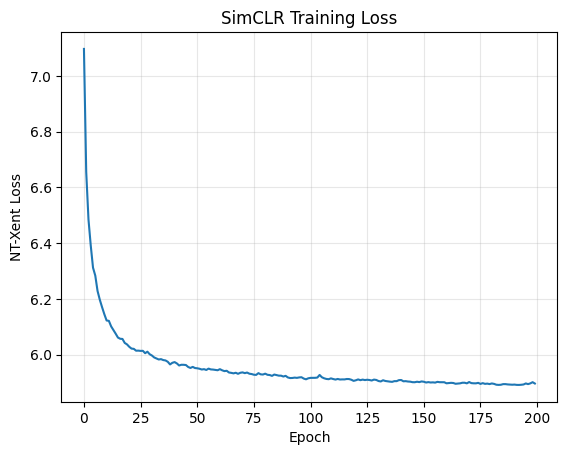

In [17]:
simclr_model = SimCLR().to(device)
simclr_optimizer = optim.Adam(simclr_model.parameters(), lr=1e-3)

simclr_losses = []
SIMCLR_EPOCHS = 200

print("Training SimCLR...")
for epoch in range(SIMCLR_EPOCHS):
    epoch_loss = 0
    for view1, view2, _, _ in simclr_dataloader:
        view1, view2 = view1.to(device), view2.to(device)

        simclr_optimizer.zero_grad()
        proj1 = simclr_model(view1)
        proj2 = simclr_model(view2)

        loss = nt_xent_loss(proj1, proj2)
        loss.backward()
        simclr_optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(simclr_dataloader)
    simclr_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: {avg_loss:.5f}")

plt.plot(simclr_losses)
plt.title("SimCLR Training Loss")
plt.xlabel("Epoch")
plt.ylabel("NT-Xent Loss")
plt.grid(alpha=0.3)
plt.show()

In [18]:
simclr_model.eval()
simclr_features = []
simclr_piece_labels = []
simclr_piece_images = []

with torch.no_grad():
    for view1, _, batch_labels, original_images in DataLoader(simclr_dataset, batch_size=2048):
        view1 = view1.to(device)
        batch_features = simclr_model.encoder(view1)

        simclr_features.append(batch_features.cpu().numpy())
        simclr_piece_labels.append(batch_labels.numpy())
        simclr_piece_images.append(original_images.squeeze().numpy())

simclr_features = np.concatenate(simclr_features)
simclr_piece_labels = np.concatenate(simclr_piece_labels)
simclr_piece_images = np.concatenate(simclr_piece_images)

print("SimCLR feature shape:", simclr_features.shape)

SimCLR feature shape: (16247, 32)


## 2.5 Visualization

In [19]:
tsne_simclr = TSNE(n_components=2, perplexity=30, random_state=42)
simclr_latent_2d = tsne_simclr.fit_transform(simclr_features)

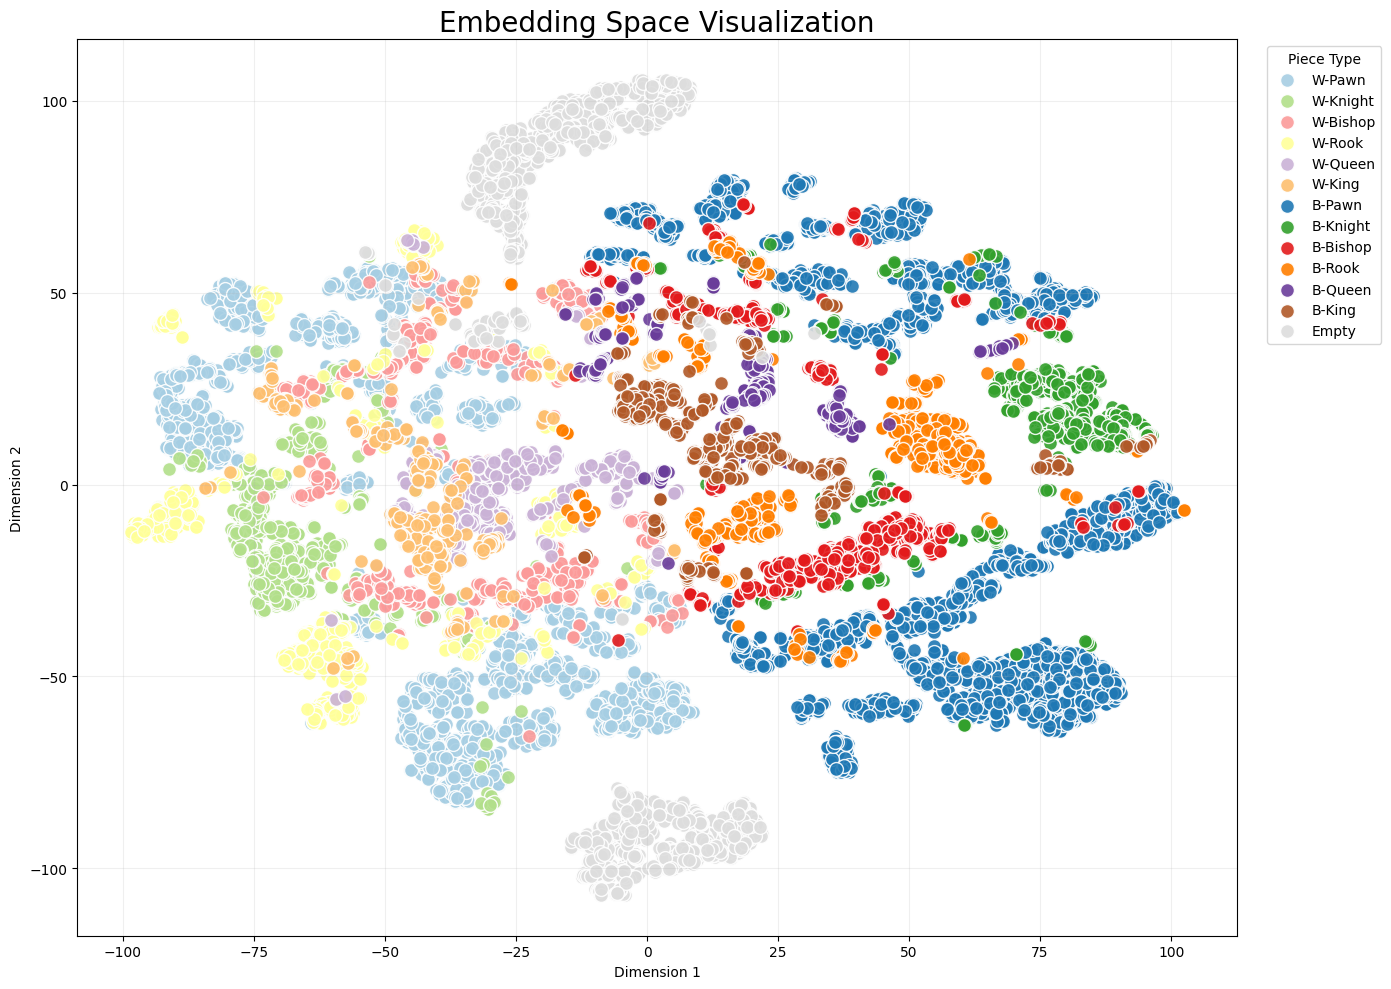

In [20]:
visualize_embedding_space(
    simclr_latent_2d,
    simclr_piece_labels,
    simclr_piece_images,
    #image_config={'wk':20, 'wq':20}
)

# 2.6 Save the encoder weights


In [21]:
torch.save(simclr_model.encoder.state_dict(), "simclr_encoder.pth")
print("Encoder model saved successfully as 'simclr_encoder.pth'")

Encoder model saved successfully as 'simclr_encoder.pth'


# 3. Notes

## 3.1 Autoencoder architechture

**Enconder**

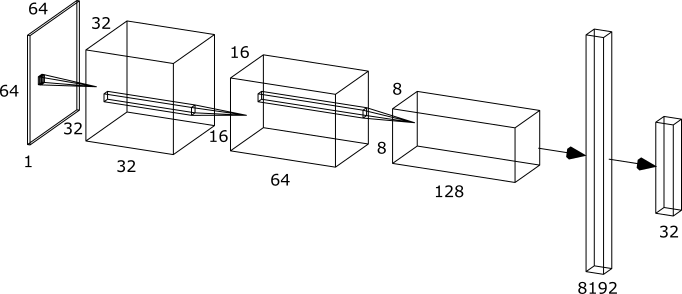

**Decoder**

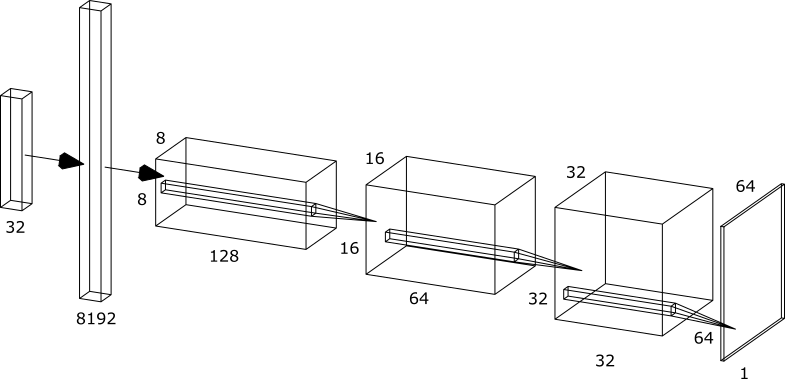

## 3.2 Autoencoder: Latent Space Interpolation

In [22]:
def morph_chess_pieces(model, latent_vectors, start_idx, end_idx, 
                       num_steps=12, device='cuda'):
    """Performs linear interpolation in the latent space and decodes the resulting images."""
    start_vector = latent_vectors[start_idx]
    end_vector = latent_vectors[end_idx]
    
    alphas = np.linspace(0, 1, num_steps).reshape(-1, 1)
    interpolated_vectors = (1 - alphas) * start_vector + alphas * end_vector

    model.eval()
    with torch.no_grad():
        latent_tensor = torch.tensor(interpolated_vectors, 
                                    dtype=torch.float32).to(device)
        generated_images = model.decoder(latent_tensor).cpu().numpy()

    plt.figure(figsize=(2 * num_steps, 2))
    for i in range(num_steps):
        ax = plt.subplot(1, num_steps, i + 1)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        plt.axis('off')
            
    plt.tight_layout()
    plt.show()

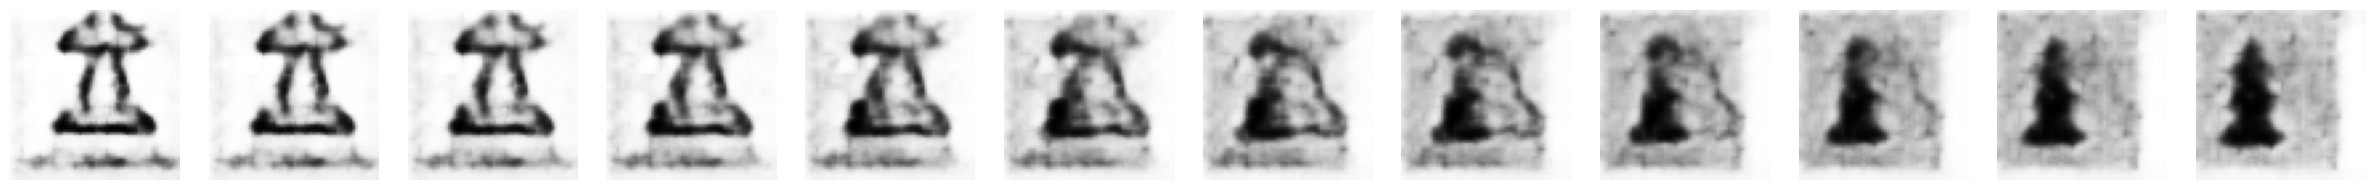

In [23]:
white_pawn_idx = np.where(ae_piece_labels == piece_map['wp'])[0][20]
black_pawn_idx = np.where(ae_piece_labels == piece_map['bp'])[0][20]
morph_chess_pieces(ae_model, ae_latent_vectors, white_pawn_idx, black_pawn_idx, num_steps=12)

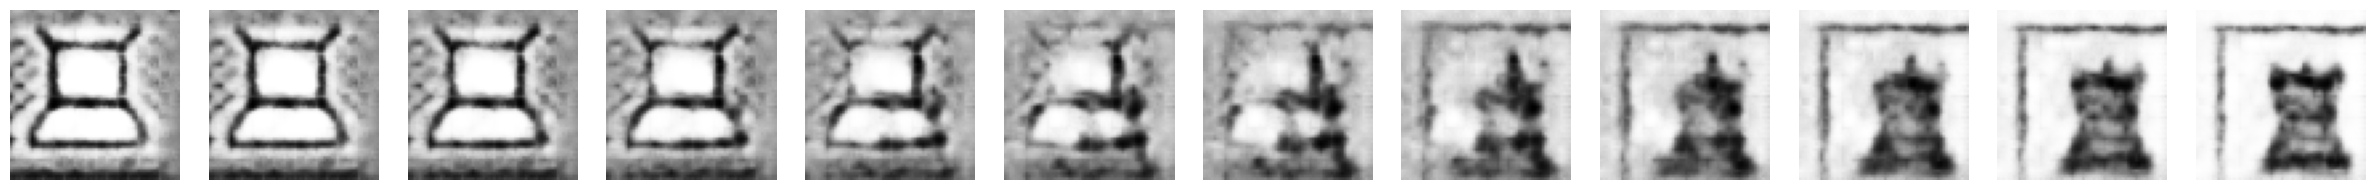

In [24]:
idx1 = np.where(ae_piece_labels == piece_map['wr'])[0][40]
idx2 = np.where(ae_piece_labels == piece_map['br'])[0][1]
morph_chess_pieces(ae_model, ae_latent_vectors, idx1, idx2, num_steps=12)

## 3.3 Vector Interpolation Visualisation

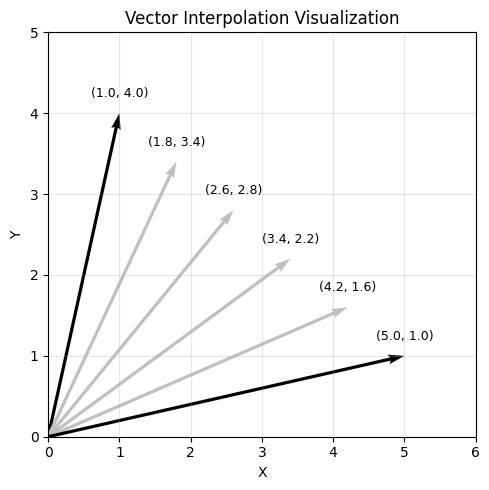

In [25]:
# Sample data
vector_start = np.array([1, 4])
vector_end = np.array([5, 1])
num_interpolation_steps = 6

alphas = np.linspace(0, 1, num_interpolation_steps).reshape(-1, 1)
interpolated_vectors = (1 - alphas) * vector_start + alphas * vector_end

# Plot
plt.figure(figsize=(5, 5))
arrow_colors = ['black'] + ['silver'] * (num_interpolation_steps - 2) + ['black']

plt.quiver(np.zeros(num_interpolation_steps), 
          np.zeros(num_interpolation_steps), 
          interpolated_vectors[:, 0], 
          interpolated_vectors[:, 1], 
          color=arrow_colors, 
          angles='xy', 
          scale_units='xy', 
          scale=1)

for x_coord, y_coord in interpolated_vectors:
    plt.text(x_coord, y_coord + 0.2, f"({x_coord:.1f}, {y_coord:.1f})", 
            ha='center', fontsize=9)

plt.xlim(0, 6)
plt.ylim(0, 5)
plt.title("Vector Interpolation Visualization")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 3.4 Why NT-Xent is just Cross-Entropy
**1. The NT-Xent Formula**
$$
\ell_{i,j} = - \log 
\frac{
    \exp \big( \mathrm{sim}(\mathbf{z}_i, \mathbf{z}_j) / \tau \big)
}{
    \sum_{k=1}^{2N} \mathbf{1}_{[k \neq i]} \exp \big( \mathrm{sim}(\mathbf{z}_i, \mathbf{z}_k) / \tau \big)
}
$$

Where:  

- $\mathbf{z}_i, \mathbf{z}_j$ are normalized embeddings of a positive pair  
- $\mathrm{sim}(\mathbf{u}, \mathbf{v}) = \frac{\mathbf{u} \cdot \mathbf{v}}{\|\mathbf{u}\| \|\mathbf{v}\|}$ is cosine similarity  
- $\tau$ is the temperature parameter  
- $N$ is the batch size

The key insight is that Contrastive Learning is just **classification** where the "correct class" is the positive pair.

**2. The Cross-Entropy Formula**
Cross-Entropy measures the difference between the true distribution $p$ and predicted distribution $q$:
$$
\mathcal{L} = - \sum_{k} p(k) \log q(k)
$$

**3. The "One-Hot" Insight**
In our batch, we know exactly which image is the positive pair.
*   **Target ($p$):** The probability is $1$ for the positive pair ($pos$) and $0$ for all others.
*   **Effect:** The summation disappears. We only care about the term where $p(k)=1$.

$$
\mathcal{L} = - \big[ 1 \cdot \log q(pos) + 0 + \dots \big] \quad \implies \quad \mathcal{L} = - \log q(pos)
$$

**4. From Scores to Probabilities (Softmax)**
Cross-Entropy requires a **probability** $q$, but our model outputs raw similarity scores (logits).

We use **Softmax** to convert these scores into a probability distribution.
$q(pos)$ represents the model's confidence that the positive pair is the correct match:

$$
q(pos) = \frac{\exp(s_{pos})}{\sum_{k} \exp(s_k)} \quad \approx \quad \frac{\text{Strength of Positive Match}}{\text{Total Strength of All Matches}}
$$

**5. The Final Form**
Substituting $q(pos)$ back into the loss equation gives us the NT-Xent loss:

$$
\mathcal{L} = - \log \left( \frac{\exp(s_{pos})}{\sum_{k} \exp(s_k)} \right)
$$

> **Conclusion:** NT-Xent is mathematically identical to standard Cross-Entropy Loss where the logits are $s = \text{sim}(z_i, z_k) / \tau$.